In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pltfrom 

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.utils import np_utils
import seaborn as sns 
sns.set_style('white')


Using TensorFlow backend.


In [2]:
# %load helpers.py
import numpy as np
import contextlib

def combine_histories(h1, h2):
    """
    Combine two history dicts -- appends the value lists to each other.

    Returns new dict.
    """
    d = {}
    for k in h1:
        d[k] = np.append(h1[k],h2[k])
    return d


# Some magic to make numpy arrays look prettier
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)


In [3]:
# %load display.py
"""
Display utilities.
"""
# (Note: I ran
# pip install pydot==1.1.0
# and pip install graphviz
# and installed the graphviz OS X package with binary libraries
# to get this to work. May not actually need the pydot downgrade...)
from IPython.display import SVG

import keras
try:
    from keras.utils.vis_utils import model_to_dot
except ImportError:
    # 1.x had a different module name.
    from keras.utils.visualize_util import model_to_dot
    

import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix


def visualize_keras_model(model):
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))


def plot_training_curves(history):
    """
    Plot accuracy and loss curves for training and validation sets.

    Args:
        history: a Keras History.history dictionary

    Returns:
        mpl figure.
    """
    fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(8,2))
    if 'acc' in history:
        ax_acc.plot(history['acc'], label='acc')
        if 'val_acc' in history:
            ax_acc.plot(history['val_acc'], label='Val acc')
        ax_acc.set_xlabel('epoch')
        ax_acc.set_ylabel('accuracy')
        ax_acc.legend(loc='upper left')
        ax_acc.set_title('Accuracy')

    ax_loss.plot(history['loss'], label='loss')
    if 'val_loss' in history:
        ax_loss.plot(history['val_loss'], label='Val loss')
    ax_loss.set_xlabel('epoch')
    ax_loss.set_ylabel('loss')
    ax_loss.legend(loc='upper right')
    ax_loss.set_title('Loss')

    sns.despine(fig)
    return fig


def plot_confusion_matrix(labels, predictions,
                          classes,
                          normalize=False,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
    """
    Plot a confusion matrix for predictions vs labels.
    Both should be one-hot.

    Based on.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # convert from one-hot
    cat_labels = np.argmax(labels, axis=1)
    cat_predicts = np.argmax(predictions, axis=1)

    cm = confusion_matrix(cat_labels, cat_predicts)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    #print(cm)

    thresh = cm.max() / 2.
    for i, j in it.product(range(cm.shape[0]), range(cm.shape[1])):
        if 0 < cm[i,j] < 1:
            val = "{:.2f}".format(cm[i,j])
        else:
            val = cm[i,j]
        plt.text(j, i, val,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return cm


In [4]:
from helpers import printoptions  # make numpy printouts prettier
from display import plot_training_curves, visualize_keras_model

In [5]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [52]:
X_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ..., 
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ..., 
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ..., 
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ..., 
       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ..., 
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ..., 
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ..., 
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,

In [6]:
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_train=X_train/255.0
X_test=X_test/255.0

In [7]:
X_train=X_train.reshape(50000,3072)
X_test=X_test.reshape(10000,3072)

In [76]:
print(X_train.shape)

(50000, 3072)


In [8]:
print(X_train.shape, 'train samples')
print(X_test.shape[0], 'test samples')

(50000, 3072) train samples
10000 test samples


In [8]:
Y_train = np_utils.to_categorical(Y_train,10)
Y_test = np_utils.to_categorical(Y_test,10)


In [81]:
Y_train.shape

(50000, 10)

In [9]:
epoch=100
numClasses=Y_test.shape[1]
batchSize=128

In [10]:


model = Sequential()
model.add(Dense(1024, input_shape=(3072,), name="hidden"))
model.add(Activation('relu', name="ReLU"))
model.add(Dense(128, name="hidden1"))
model.add(Activation('softmax', name="ReLu"))
model.add(Dense(10, name="output"))
model.add(Activation('softmax', name="softmax"))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 1024)              3146752   
_________________________________________________________________
ReLU (Activation)            (None, 1024)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 128)               131200    
_________________________________________________________________
ReLu (Activation)            (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 10)                1290      
_________________________________________________________________
softmax (Activation)         (None, 10)                0         
Total params: 3,279,242
Trainable params: 3,279,242
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),              
              metrics=['accuracy'])



In [23]:
!pip install pydot
!pip install graphviz


In [24]:
visualize_keras_model(model)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [14]:
history= model.fit(X_train,Y_train, epochs=10, batch_size=128, verbose=1);
score = model.evaluate(X_test,Y_test, verbose=0)
print(score)

Epoch 1/10
50000/50000 [==============================] - 50s - loss: 1.9554 - acc: 0.2503    
Epoch 2/10
50000/50000 [==============================] - 47s - loss: 1.9171 - acc: 0.2754    
Epoch 3/10
50000/50000 [==============================] - 53s - loss: 1.8703 - acc: 0.3097    
Epoch 4/10
50000/50000 [==============================] - 52s - loss: 1.8223 - acc: 0.3393    
Epoch 5/10
50000/50000 [==============================] - 50s - loss: 1.7752 - acc: 0.3629    
Epoch 6/10
50000/50000 [==============================] - 52s - loss: 1.7300 - acc: 0.3878    
Epoch 7/10
50000/50000 [==============================] - 53s - loss: 1.6894 - acc: 0.4042    
Epoch 8/10
50000/50000 [==============================] - 53s - loss: 1.6550 - acc: 0.4161    
Epoch 9/10
50000/50000 [==============================] - 64s - loss: 1.6268 - acc: 0.4273    
Epoch 10/10
50000/50000 [==============================] - 63s - loss: 1.5999 - acc: 0.4414    
[1.6521249320983886, 0.41949999999999998]


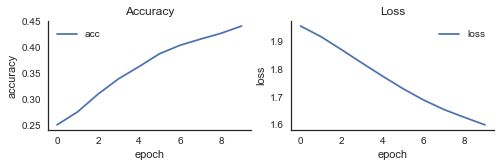

In [15]:
plot_training_curves(history.history);

[1.5877029226303101, 0.4929]


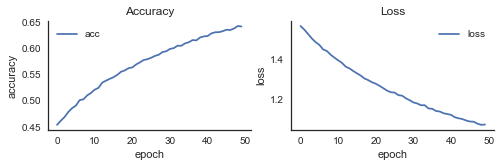

In [16]:
history1= model.fit(X_train,Y_train, epochs=50, batch_size=128, verbose=0);
score = model.evaluate(X_test,Y_test, verbose=0)
print(score)
plot_training_curves(history1.history);